## **Цели и задачи исследования**
***
**Цель исследования** - *создать модель, которая предсказывает рейтинги ресторана по данным сайта TripAdvisor на основе имеющихся данных.*

*Целью исследования определяются следующие* **задачи:**

* *повести разведавательный анализ данных;*
* *разработать модель, которая бы предсказывала рейтинг ресторана.*

<img src="https://i.pinimg.com/originals/d0/fa/0f/d0fa0fd589252dcbfc07658c64112a9e.jpg" />

### 1. Импортирование инструментов и библиотек


In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime, date, time

# Библиотеки и настройки для вывода визуализаций
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Опция для вывода всех строк и столбцов
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

# Библиотеки для нормирования данных
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Инструмент для разбивки данных
from sklearn.model_selection import train_test_split

# Инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor

# Инструмент для оценки точности модели
from sklearn import metrics # инструменты для оценки точности модел

# Воспроизводимость экспериментов
RANDOM_SEED = 42

# Фиксация версий пакетов для воспроизводимости экспериментов
!pip freeze > requirements.txt

### 2. Чтение файла и первичное исследование данных

In [2]:
train = pd.read_csv('main_task.csv')
train.info()

# Добавим столбец sample, в котором отметим данные как тренировочные
train['sample']='train'
train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,train
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,train
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,train


In [3]:
test = pd.read_csv('kaggle_task.csv')
test.info()

# В тестовых данных отсутствует столбец rating, добавляем его
test['Rating']=0

# Добавим столбец sample, в котором отметим данные как тестовые
test['sample']='test'
test.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Rating,sample
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,test
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,test
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,test


In [4]:
# Объединяем тестовый и тренировочный датасеты, функция append помогает избежать дубликатов
data = test.append(train, sort=False)

# Переименовываем столбцы
data.columns = ['id','city','cuisine_style','rankin','price_range','number_of_reviews','reviews','URL','id_URL','rating',
                'sample']
data.info()
data.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 39999
Data columns (total 11 columns):
id                   50000 non-null object
city                 50000 non-null object
cuisine_style        38410 non-null object
rankin               50000 non-null float64
price_range          32639 non-null object
number_of_reviews    46800 non-null float64
reviews              49998 non-null object
URL                  50000 non-null object
id_URL               50000 non-null object
rating               50000 non-null float64
sample               50000 non-null object
dtypes: float64(3), object(8)
memory usage: 4.6+ MB


,id,city,cuisine_style,rankin,price_range,number_of_reviews,reviews,URL,id_URL,rating,sample
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0.0,test
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0.0,test
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0.0,test


In [5]:
sample_submission=pd.read_csv('sample_submission.csv')
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


**Комментарий:** работа будет проведена над таблицей, состоящей из 50000 строк, 11 столбцов, из которых 4 столбца содержат значения типа "NaN". Первая часть датасета (40000 строк) - тренинговая, вторая часть (10000 строк) - тестовая.

Столбцы таблицы имеют следующее описание:
* id — идентификационный номер ресторана / сети ресторанов;
* сity — город, в котором находится ресторан;
* сuisine_style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
* rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* price_range — диапазон цен в ресторане;
* number_of_reviews — количество отзывов о ресторане;
* reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
* URL — URL страницы ресторана на TripAdvosor;
* id_URL — идентификатор ресторана в базе данных TripAdvisor.

### 3. Используемые для обработки данных функции

In [6]:
def description_column(x):
    
    """Функция используется для описания 
     значений в столбце"""
    
    print('Количество уникальных значений в столбце:',x.nunique(),'или',round((x.nunique()/len(x))*100,2),'%.')
    print('Перечень уникальных значений:', x.unique())
    print('Длина столбца:',len(x))
    print('Количество значений "NaN":', x.isna().sum())
    
    
def cuisine_style(x):
    
    """Функция используется для преобразования 
     столбца с типами кухонь"""
    
    i = 0
    for g in x:
        # Разделение списка значений
        f = x[i].split(',')
        # Ввод счетчика
        v = 0
        for g in f:
            # Выбор слов и замена кавычек
            h = f[v][2:-1].replace("'", '')
            # Добавление элемента в счетчик
            v = +1
            list_cuisine_style.append(h)
        i += 1   

def find_item(cell):
    
    """Функция используется для добавления
    признака наличия типа кухни в списк"""    
    
    if item in cell:
        return 1
    return 0


def bar_groupby(x,y,t,xl,yl):
    
    """Функция используется для 
    вывода диаграммы по нескольким признакам"""
    
    data_new.groupby(by=[x])[y].mean().sort_values(ascending=False).plot(kind = 'bar',color = 'goldenrod',title = t)
    plt.xlabel(xl, fontsize=11, color='black')
    plt.ylabel(yl, fontsize=11, color='black')
    plt.grid(True)
    plt.show()

### 4. Ознакомление с данными в столбцах таблицы

**Этапы анализа:** 
* Определить количество нулевых значений, уникальных значений;
* Обработать нулевые значения:
    1. заполнить, опираясь на информацию из других столбцов;
    2. удалить нулевые значения;
    3. заполнить статистикой;
* Заменить категориальные данные на числовые.

### 4.1 id

In [7]:
# Описание столбца id
description_column(data['id'])

Количество уникальных значений в столбце: 13094 или 26.19 %.
Перечень уникальных значений: ['id_0' 'id_1' 'id_2' ... 'id_15736' 'id_12774' 'id_11658']
Длина столбца: 50000
Количество значений "NaN": 0


In [8]:
# Приведем столбец id к числовому типу
data['id']=data['id'].apply(lambda x: x.replace('id_','')).apply(lambda x: pd.to_numeric(x))

In [9]:
# Добавим количество ресторанов одной сети
dict_count =dict(data['id'].value_counts())
Chain =pd.DataFrame({'count':dict_count}, columns=['count'])
A=Chain.index
B=Chain.values
data['chain']= data['id'].replace(A, B)
data.info()
data.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 39999
Data columns (total 12 columns):
id                   50000 non-null int64
city                 50000 non-null object
cuisine_style        38410 non-null object
rankin               50000 non-null float64
price_range          32639 non-null object
number_of_reviews    46800 non-null float64
reviews              49998 non-null object
URL                  50000 non-null object
id_URL               50000 non-null object
rating               50000 non-null float64
sample               50000 non-null object
chain                50000 non-null int64
dtypes: float64(3), int64(2), object(7)
memory usage: 5.0+ MB


,id,city,cuisine_style,rankin,price_range,number_of_reviews,reviews,URL,id_URL,rating,sample,chain
0,0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0.0,test,16
1,1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0.0,test,10
2,2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0.0,test,15


**Комментарий:** в столбце id нет нулевых значений, но есть дублирующие id - несколько ресторанов одной сети. Чтобы посмотреть, сколько ресторанов входит в одну сеть был создан словарь типа {'id': количество id}. Данные о количестве ресторанов были добавлены в датасет: столбец chain.

### 4.2 City

In [10]:
# Описание столбца city
description_column(data['city'])

Количество уникальных значений в столбце: 31 или 0.06 %.
Перечень уникальных значений: ['Paris' 'Helsinki' 'Edinburgh' 'London' 'Bratislava' 'Lisbon' 'Budapest'
 'Stockholm' 'Rome' 'Milan' 'Munich' 'Hamburg' 'Prague' 'Vienna' 'Dublin'
 'Barcelona' 'Brussels' 'Madrid' 'Oslo' 'Amsterdam' 'Berlin' 'Lyon'
 'Athens' 'Warsaw' 'Oporto' 'Krakow' 'Copenhagen' 'Luxembourg' 'Zurich'
 'Geneva' 'Ljubljana']
Длина столбца: 50000
Количество значений "NaN": 0


In [11]:
# Приведем столбец city к числовому виду

# Создаем список уникальных значений
A = list(data.city.value_counts().keys())

# Создаем список числовых значений по длине списка городов
B = range(0, len(A))

# Объединяем два спсика
dict_city = dict(zip(A, B))

# Добавляем числовой столбец city_id
data['city_id'] = data['city'].replace(A, B)
data.info()
data.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 39999
Data columns (total 13 columns):
id                   50000 non-null int64
city                 50000 non-null object
cuisine_style        38410 non-null object
rankin               50000 non-null float64
price_range          32639 non-null object
number_of_reviews    46800 non-null float64
reviews              49998 non-null object
URL                  50000 non-null object
id_URL               50000 non-null object
rating               50000 non-null float64
sample               50000 non-null object
chain                50000 non-null int64
city_id              50000 non-null int64
dtypes: float64(3), int64(3), object(7)
memory usage: 5.3+ MB


,id,city,cuisine_style,rankin,price_range,number_of_reviews,reviews,URL,id_URL,rating,sample,chain,city_id
0,0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0.0,test,16,1
1,1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0.0,test,10,27
2,2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0.0,test,15,21


**Комментарий:** рейтинг ресторана может зависеть от города. Города различаются по численности населения. Есть предположение, что в крупных городах может быть больше отзывов и выше рейтинги. Поэтому **первый признак**, который можно добавить в датасет - численность населения города. 

Ресторанный бизнес - лидер по числу банкротств. Удержаться на рынке - задача непростая и успешные рестораны с высокими рейтингами отличаются хорошим сервисом, удобным расположением, дополнительными услугами, акциями, уникальным меню. Чтобы стать высококонкурентным рестораном нужен и постоянный поток клиентов. Мы можем предположить что, если город входит в рейтинг популярных туристических направлений, то ресторанный бизнес в таком городе более развит и рейтинги выше, поэтому **второй признак** - количество туристов в год.



**Комментарий на будущее:** мы опредили всего-лишь два признака, хотя их намного больше:
1. расстояние от ресторана до центра города;
2. расстояние от ресторана до основных достопримечательностей;
3. наличие специализированного меню (для вегетарианцев);
4. оценка ресторана путешественниками;
5. наличие наград (например: Travellers' Choice);
6. размер скидок по акциям.

Для обогащения данных на данном этапе нехватает навыков парсинга сайта, поэтому берем на заметку, что модель можно улучшить.

In [12]:
# Создаем таблицу с городами и странами
dict_country=[{'city':'Paris','country':'France'},
              {'city':'Helsinki','country':'Finland'},
              {'city':'Edinburgh','country':'United Kingdom'},
              {'city':'London','country':'United Kingdom'},
              {'city':'Bratislava','country':'Slovakia'},
              {'city':'Lisbon','country':'Portugal'},
              {'city':'Budapest','country':'Hungary'},
              {'city':'Stockholm','country':'Sweden'},
              {'city':'Rome','country':'Italy'},
              {'city':'Milan','country':'Italy'},
              {'city':'Munich','country':'Germany'},
              {'city':'Hamburg','country':'Germany'},
              {'city':'Prague','country':'Czech Republic'},
              {'city':'Vienna','country':'Austria'},
              {'city':'Dublin','country':'Ireland'},
              {'city':'Barcelona','country':'Belgium'},
              {'city':'Brussels','country':'Belgium'},
              {'city':'Madrid','country':'Italy'},
              {'city':'Oslo','country':'Norway'},
              {'city':'Amsterdam','country':'Netherlands'},
              {'city':'Berlin','country':'Netherlands'},
              {'city':'Lyon','country':'France'},
              {'city':'Athens','country':'Greece'},
              {'city':'Warsaw','country':'Poland'},
              {'city':'Oporto','country':'Portugal'},
              {'city':'Krakow','country':'Poland'},
              {'city':'Copenhagen','country':'Denmark'},
              {'city':'Luxembourg','country':'Luxembourg'},
              {'city':'Zurich','country':'Switzerland'},
              {'city':'Geneva','country':'Switzerland'},
              {'city':'Ljubljana','country':'Slovenia'}]
dict_country=pd.DataFrame(dict_country)

# Удаляем пропуски
dict_country['city']=dict_country['city'].apply(lambda x: x.strip())
dict_country.info()
dict_country.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
city       31 non-null object
country    31 non-null object
dtypes: object(2)
memory usage: 624.0+ bytes


,city,country
0,Paris,France
1,Helsinki,Finland
2,Edinburgh,United Kingdom


In [13]:
# С сайта евростата импортируем таблицу с данными о численности населения европейских городов
Population = pd.read_excel('urb_cpop1.xls',skiprows = 7, header = 1, usecols = [0,10], names = ['city','population'])

# Описание столбца city
description_column(Population['city'])

# Проводим предобработку датасета
Population=Population[Population['population'].isnull()==False].drop_duplicates()
Population['city']=Population['city'].apply(lambda x: x.strip())
Population['city']=Population['city'].apply(lambda x: x.replace('Cityof','')) 
Population['city']=Population['city'].apply(lambda x: x.replace('Greater ','')) 
Population['city']=Population['city'].apply(lambda x: x.replace('Lisboa','Lisbon'))
Population['city']=Population['city'].apply(lambda x: x.replace('Roma','Rome'))
Population['city']=Population['city'].apply(lambda x: x.replace('München','Munich'))
Population['city']=Population['city'].apply(lambda x: x.replace('Praha','Prague'))
Population['city']=Population['city'].apply(lambda x: x.replace('Bruxelles / Brussel','Brussels'))
Population['city']=Population['city'].apply(lambda x: x.replace('Warszawa','Warsaw'))
Population['city']=Population['city'].apply(lambda x: x.replace('Geneve','Geneva'))
Population['city']=Population['city'].apply(lambda x: x.replace(' / Helsingfors',''))
Population['city']=Population['city'].apply(lambda x: x.replace('City of ',''))
Population['city']=Population['city'].apply(lambda x: x.replace('Milano','Milan'))
Population['city']=Population['city'].apply(lambda x: x.replace('Kraków','Krakow'))
Population['city']=Population['city'].apply(lambda x: x.replace('Zürich','Zurich'))

# Объединяем датасеты со списком стран и численностью населения
dictionary=dict_country.merge(Population, on ='city', how='left')
dictionary.info()
dictionary.head(3)

Количество уникальных значений в столбце: 1043 или 98.49 %.
Перечень уникальных значений: ['Belgium' 'Bruxelles / Brussel' 'Antwerpen' ... 'Krakow' 'Copenhagen'
 'Geneva']
Длина столбца: 1059
Количество значений "NaN": 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 3 columns):
city          31 non-null object
country       31 non-null object
population    31 non-null float64
dtypes: float64(1), object(2)
memory usage: 992.0+ bytes


,city,country,population
0,Paris,France,2148000.0
1,Helsinki,Finland,643272.0
2,Edinburgh,United Kingdom,515855.0


In [14]:
# С сайта евростата импортируем таблицу с данными о численности туристов в европейских странах
Tourism = pd.read_csv('tour_occ_arnat_1_Data.csv')

# Фильтруем таблицу для вывода общего числа туристов, остановившихся как в гостиницах, так и в кэмпингах
Tourism=Tourism[(Tourism['TIME']==2019) & (Tourism['C_RESID']=='Total') & (Tourism['UNIT']=='Number')
               & (Tourism['NACE_R2']=="Hotels; holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks")]

# Проводим предобработку датасета
Tourism['GEO']=Tourism['GEO'].apply(lambda x: x.replace('Germany (until 1990 former territory of the FRG)','Germany'))
Tourism['GEO']=Tourism['GEO'].apply(lambda x: x.replace('Czechia','Czech Republic'))

# Переименовываем столбцы
Tourism.columns=['year','country','type_residents','unit','type','tourists','flag and footnotes']

# Объединяем датасеты со списком стран и численностью туристов
dictionary=dictionary.merge(Tourism, on ='country', how='left')

# Изменяем тип данных столбцов
dictionary['population']=dictionary['population'].apply(pd.to_numeric)
dictionary['tourists']=dictionary['tourists'].apply(lambda x: x.replace(',','')).apply(pd.to_numeric)

# Переименовываем столбцы
statistica=dictionary[['city','country','population','tourists']]
statistica.head(3)

,city,country,population,tourists
0,Paris,France,2148000.0,174628055
1,Helsinki,Finland,643272.0,12426677
2,Edinburgh,United Kingdom,515855.0,37000000


In [15]:
# Добавляем данные о численности населения и туристов в основной датасет
data_new=data.merge(statistica, on ='city', how='left')
data_new.info()
data_new.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 16 columns):
id                   50000 non-null int64
city                 50000 non-null object
cuisine_style        38410 non-null object
rankin               50000 non-null float64
price_range          32639 non-null object
number_of_reviews    46800 non-null float64
reviews              49998 non-null object
URL                  50000 non-null object
id_URL               50000 non-null object
rating               50000 non-null float64
sample               50000 non-null object
chain                50000 non-null int64
city_id              50000 non-null int64
country              50000 non-null object
population           50000 non-null float64
tourists             50000 non-null int64
dtypes: float64(4), int64(4), object(8)
memory usage: 6.5+ MB


,id,city,cuisine_style,rankin,price_range,number_of_reviews,reviews,URL,id_URL,rating,sample,chain,city_id,country,population,tourists
0,0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0.0,test,16,1,France,2148000.0,174628055
1,1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0.0,test,10,27,Finland,643272.0,12426677
2,2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0.0,test,15,21,United Kingdom,515855.0,37000000


In [16]:
# Добавляем количество отзывов о ресторане, деленное на население города
data_new['number_of_reviews/population']=data_new['number_of_reviews']/data_new['population']
# Заполним пустые ячейки нулями
data_new['number_of_reviews/population']=data_new['number_of_reviews/population'].fillna(0)

# Добавим количество туристов, деленное на население города
data_new['tourists/population']=data_new['tourists']/data_new['population']
# Заполним пустые ячейки нулями
data_new['tourists/population']=data_new['tourists/population'].fillna(0)

data_new.info()
data_new.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 18 columns):
id                              50000 non-null int64
city                            50000 non-null object
cuisine_style                   38410 non-null object
rankin                          50000 non-null float64
price_range                     32639 non-null object
number_of_reviews               46800 non-null float64
reviews                         49998 non-null object
URL                             50000 non-null object
id_URL                          50000 non-null object
rating                          50000 non-null float64
sample                          50000 non-null object
chain                           50000 non-null int64
city_id                         50000 non-null int64
country                         50000 non-null object
population                      50000 non-null float64
tourists                        50000 non-null int64
number_of_reviews/populatio

,id,city,cuisine_style,rankin,price_range,number_of_reviews,reviews,URL,id_URL,rating,sample,chain,city_id,country,population,tourists,number_of_reviews/population,tourists/population
0,0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0.0,test,16,1,France,2148000.0,174628055,0.000002,81.297977
1,1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0.0,test,10,27,Finland,643272.0,12426677,0.000151,19.317920
2,2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0.0,test,15,21,United Kingdom,515855.0,37000000,0.000054,71.725582


**Комментарий:** была проведена обработка столбца 'city', добавлены новые признаки: страна, численность населения, количество туристов, количество отзывов о ресторане на 1 жителя города, количество туристов на 1 жителя города.

### 4.3 Cuisine_style

In [17]:
# Описание столбца 'cuisine_style'
description_column(data_new['cuisine_style'])

Количество уникальных значений в столбце: 10731 или 21.46 %.
Перечень уникальных значений: ["['Bar', 'Pub']"
 "['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']"
 "['Vegetarian Friendly']" ...
 "['Steakhouse', 'Barbecue', 'Australian', 'Argentinean', 'South American']"
 "['French', 'American', 'Cafe', 'Healthy', 'Soups']"
 "['French', 'Contemporary', 'Fusion', 'Gastropub']"]
Длина столбца: 50000
Количество значений "NaN": 11590


**Комментарий:** обработку данных в столбце 'cuisine_style' усложняет наличие нулевых значений и то, что в одной строке может содержаться список всех возможных стилей кухнь в ресторане. Предлагается заменить нулевые значения на "No_information", а из списка кухнь выбрать самые популярные.

In [18]:
# Заменим пустые значения (11590 шт.) на "No_information"
data_new['cuisine_style'] = data_new['cuisine_style'].fillna('""No_information"')

data_new['cuisine_style'].isnull().value_counts()
print("Столбец 'cuisine_style' не содержит нулевых значений")

Столбец 'cuisine_style' не содержит нулевых значений


In [19]:
# Удаляем все нулевые значения в столбце 'cuisine_style' и формируем список стилей кухнь
df = pd.DataFrame(data_new['cuisine_style'].dropna())
cuisine = list(df['cuisine_style'])

# Создаем пустой список, который будем содержать обработанные значения
list_cuisine_style = list()

# Применяем функцию для обработки значений
cuisine_style(cuisine)
list_cuisine_style[0:5]

['Bar', 'Pub', 'European', 'Scandinavian', 'Scandinavian']

In [20]:
# Посчитаем количество типов кухнь
cuisine_style_coun=Counter(list_cuisine_style)
cuisine_style_coun=dict(cuisine_style_coun)
cuisine_style_coun=pd.DataFrame({'count':cuisine_style_coun}, columns=['count'])

# Определим среднее количество кухнь
mean_=cuisine_style_coun['count'].mean()

# Создадим список самых популярных кухонь (количество > среднего значения)
popular_cuisine=list(cuisine_style_coun.query('count > @mean_').index)
popular_cuisine

['American',
 'Asian',
 'Bar',
 'British',
 'Cafe',
 'Chinese',
 'European',
 'Fast Food',
 'French',
 'Indian',
 'International',
 'Italian',
 'Japanese',
 'Mediterranean',
 'No_information',
 'Pizza',
 'Pub',
 'Seafood',
 'Spanish',
 'Sushi',
 'Thai',
 'Vegetarian Friendly']

In [21]:
# Преобразуем строки с типами кухонь в солбцы
for item in popular_cuisine:
    data_new[item] = data_new['cuisine_style'].apply(find_item)
    
# Заменяем название типа кухонь на число
data_new['cuisine_style'] = data_new['cuisine_style'].apply(lambda x: len(x))
len(data_new['cuisine_style'])

data_new.info()
data_new.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 40 columns):
id                              50000 non-null int64
city                            50000 non-null object
cuisine_style                   50000 non-null int64
rankin                          50000 non-null float64
price_range                     32639 non-null object
number_of_reviews               46800 non-null float64
reviews                         49998 non-null object
URL                             50000 non-null object
id_URL                          50000 non-null object
rating                          50000 non-null float64
sample                          50000 non-null object
chain                           50000 non-null int64
city_id                         50000 non-null int64
country                         50000 non-null object
population                      50000 non-null float64
tourists                        50000 non-null int64
number_of_reviews/population

,id,city,cuisine_style,rankin,price_range,number_of_reviews,reviews,URL,id_URL,rating,sample,chain,city_id,country,population,tourists,number_of_reviews/population,tourists/population,American,Asian,Bar,British,Cafe,Chinese,European,Fast Food,French,Indian,International,Italian,Japanese,Mediterranean,No_information,Pizza,Pub,Seafood,Spanish,Sushi,Thai,Vegetarian Friendly
0,0,Paris,14,12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0.0,test,16,1,France,2148000.0,174628055,0.000002,81.297977,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,Helsinki,91,106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0.0,test,10,27,Finland,643272.0,12426677,0.000151,19.317920,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,Edinburgh,23,810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0.0,test,15,21,United Kingdom,515855.0,37000000,0.000054,71.725582,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


**Комментарий:** была проведена обработка столбца 'cuisine_style', нулевые значения заменены на "No_information", в конечном датасете оставлены только самые популярные типы кухнь, которые преобразованы в числовой вид.

### 4.4 Price_range

In [22]:
# Описание столбца 'price_range'
description_column(data_new['price_range'])

Количество уникальных значений в столбце: 3 или 0.01 %.
Перечень уникальных значений: ['$$ - $$$' '$$$$' '$' nan]
Длина столбца: 50000
Количество значений "NaN": 17361


In [23]:
# Замена тестовых значений на числовые
data_new['price_range'] = data_new['price_range'].replace('$', 1)
data_new['price_range'] = data_new['price_range'].replace('$$ - $$$', 2)
data_new['price_range'] = data_new['price_range'].replace('$$$$', 3)

# Нахождение среднего значения
price_mean = data_new['price_range'].mean()
price_mean = int(price_mean)

# Заполнение средними значениями пустых ячеек
data_new['price_range'] = data_new['price_range'].fillna(price_mean)

data_new.info()
data_new.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 40 columns):
id                              50000 non-null int64
city                            50000 non-null object
cuisine_style                   50000 non-null int64
rankin                          50000 non-null float64
price_range                     50000 non-null float64
number_of_reviews               46800 non-null float64
reviews                         49998 non-null object
URL                             50000 non-null object
id_URL                          50000 non-null object
rating                          50000 non-null float64
sample                          50000 non-null object
chain                           50000 non-null int64
city_id                         50000 non-null int64
country                         50000 non-null object
population                      50000 non-null float64
tourists                        50000 non-null int64
number_of_reviews/populatio

,id,city,cuisine_style,rankin,price_range,number_of_reviews,reviews,URL,id_URL,rating,sample,chain,city_id,country,population,tourists,number_of_reviews/population,tourists/population,American,Asian,Bar,British,Cafe,Chinese,European,Fast Food,French,Indian,International,Italian,Japanese,Mediterranean,No_information,Pizza,Pub,Seafood,Spanish,Sushi,Thai,Vegetarian Friendly
0,0,Paris,14,12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0.0,test,16,1,France,2148000.0,174628055,0.000002,81.297977,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,Helsinki,91,106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0.0,test,10,27,Finland,643272.0,12426677,0.000151,19.317920,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,Edinburgh,23,810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0.0,test,15,21,United Kingdom,515855.0,37000000,0.000054,71.725582,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


**Комментарий:** была проведена обработка столбца 'price_range', порядковые значения заменены на числовые, нулевые на средние.

### 4.5 Reviews	

In [24]:
# Описание столбца 'reviews'
description_column(data_new['reviews'])

Количество уникальных значений в столбце: 41857 или 83.71 %.
Перечень уникальных значений: ['[[], []]'
 "[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"
 "[['Better than the Links', 'Ivy Black'], ['12/28/2017', '12/06/2017']]"
 ...
 "[['Good by swedish standards', 'A hidden jewel in the middle of Västertorp...'], ['11/03/2016', '04/12/2008']]"
 "[['Underground restaurant', 'Oldest Restaurant in Warsaw'], ['07/11/2017', '06/18/2017']]"
 "[['Average', 'Nice an informal'], ['01/31/2016', '07/04/2012']]"]
Длина столбца: 50000
Количество значений "NaN": 2


**Комментарий:** в столбце "reviews" помимо самого отзыва содержится информация о дате записи. Предлагается вычленить дату и определить, сколько времени прошло с момента последнего отзыва.


**Комментарий на будущее:** хорошо было бы применить регулярные выражения и вычленить слова, характеризующие отзыв в  целом (good, bad, better, very good и т.д.) и заменить их на числовое значение.

In [25]:
# Замена пустых значений на 'No_information'
data_new['reviews'] = data_new['reviews'].replace("[[], []]", 'No_information')
data_new['reviews'] = data_new['reviews'].fillna('No_information')
data_new['reviews'][1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

In [26]:
data_new['last_rew']=data_new['reviews'].str[-27:-17]
data_new['last_rew'].unique()

array(['', '12/05/2017', '12/28/2017', ..., "nd chill']", "n Italy!']",
       "and more']"], dtype=object)

In [27]:
now = datetime.now()

# Приравниваем строки без даты к сегодня
data_new['last_rew'][data_new['last_rew'].str.contains("]")==True] = now
data_new['last_rew'] = data_new['last_rew'].fillna(now)
data_new['last_rew'] = [pd.to_datetime(i) for i in data_new['last_rew']]

# Добавляем сколько прошло времени с момента последнего отзыва
data_new['last_rew_data'] = data_new['last_rew']-now
data_new['last_rew_data'] = [i.total_seconds() for i in data_new['last_rew_data']]
data_new['last_rew_data'] = data_new['last_rew']
data_new['last_rew_data'] = data_new['last_rew'].fillna(0)
data_new.info()
data_new.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 42 columns):
id                              50000 non-null int64
city                            50000 non-null object
cuisine_style                   50000 non-null int64
rankin                          50000 non-null float64
price_range                     50000 non-null float64
number_of_reviews               46800 non-null float64
reviews                         50000 non-null object
URL                             50000 non-null object
id_URL                          50000 non-null object
rating                          50000 non-null float64
sample                          50000 non-null object
chain                           50000 non-null int64
city_id                         50000 non-null int64
country                         50000 non-null object
population                      50000 non-null float64
tourists                        50000 non-null int64
number_of_reviews/populatio

,id,city,cuisine_style,rankin,price_range,number_of_reviews,reviews,URL,id_URL,rating,sample,chain,city_id,country,population,tourists,number_of_reviews/population,tourists/population,American,Asian,Bar,British,Cafe,Chinese,European,Fast Food,French,Indian,International,Italian,Japanese,Mediterranean,No_information,Pizza,Pub,Seafood,Spanish,Sushi,Thai,Vegetarian Friendly,last_rew,last_rew_data
0,0,Paris,14,12963.0,2.0,4.0,No_information,/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0.0,test,16,1,France,2148000.0,174628055,0.000002,81.297977,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,NaT,0
1,1,Helsinki,91,106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0.0,test,10,27,Finland,643272.0,12426677,0.000151,19.317920,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2017-12-05,2017-12-05 00:00:00
2,2,Edinburgh,23,810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0.0,test,15,21,United Kingdom,515855.0,37000000,0.000054,71.725582,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2017-12-28,2017-12-28 00:00:00


**Комментарий:** была проведена обработка столбца 'reviews': из текста отзыва вычленена дата и посчитано количество дней с момента последнего отзыва.

### 4.6 Number_of_reviews

In [28]:
# Описание столбца 'number_of_reviews'
description_column(data_new['number_of_reviews'])

Количество уникальных значений в столбце: 1573 или 3.15 %.
Перечень уникальных значений: [   4.   97.   28. ...  765. 2272. 2297.]
Длина столбца: 50000
Количество значений "NaN": 3200


In [29]:
# Проверим, есть ли в столбце number_of_reviews отрицательные значения
data_new['number_of_reviews'].describe()
print('Отрицательных чисел в столбце "number_of_reviews" нет. Минимальное значение:',data_new['number_of_reviews'].min())

Отрицательных чисел в столбце "number_of_reviews" нет. Минимальное значение: 2.0


In [30]:
# Определим, в скольких строках есть нулевые значения
print('Нулевые значения есть в',len(data_new[data_new['number_of_reviews'].isnull()==True]),'строках.')

Нулевые значения есть в 3200 строках.


In [31]:
# Обработаем нулевые значения путем их замены на "No_information"
data_new['number_of_reviews']=data_new['number_of_reviews'].fillna(0)
print('Нулевые значения',len(data_new[data_new['number_of_reviews']=="No_information"]),'строк заменены на "No_information"')

Нулевые значения 0 строк заменены на "No_information"


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [32]:
# Заменим "NaN" на 0
# Если number_of_reviews и reviews не содержат информации, заменяем на 0
query = data_new.query('reviews == "No_information" & number_of_reviews == "No_information"')
list_number_of_reviews = list(query.index)
data_new['number_of_reviews'][list_number_of_reviews] = 0

# Проверяем
print(description_column(data_new['number_of_reviews']))
data_new.info()
data_new.head(3)

Количество уникальных значений в столбце: 1574 или 3.15 %.
Перечень уникальных значений: [   4.   97.   28. ...  765. 2272. 2297.]
Длина столбца: 50000
Количество значений "NaN": 0
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 42 columns):
id                              50000 non-null int64
city                            50000 non-null object
cuisine_style                   50000 non-null int64
rankin                          50000 non-null float64
price_range                     50000 non-null float64
number_of_reviews               50000 non-null float64
reviews                         50000 non-null object
URL                             50000 non-null object
id_URL                          50000 non-null object
rating                          50000 non-null float64
sample                          50000 non-null object
chain                           50000 non-null int64
city_id                         50000 non-null int64
cou

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,city,cuisine_style,rankin,price_range,number_of_reviews,reviews,URL,id_URL,rating,sample,chain,city_id,country,population,tourists,number_of_reviews/population,tourists/population,American,Asian,Bar,British,Cafe,Chinese,European,Fast Food,French,Indian,International,Italian,Japanese,Mediterranean,No_information,Pizza,Pub,Seafood,Spanish,Sushi,Thai,Vegetarian Friendly,last_rew,last_rew_data
0,0,Paris,14,12963.0,2.0,4.0,No_information,/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0.0,test,16,1,France,2148000.0,174628055,0.000002,81.297977,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,NaT,0
1,1,Helsinki,91,106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0.0,test,10,27,Finland,643272.0,12426677,0.000151,19.317920,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2017-12-05,2017-12-05 00:00:00
2,2,Edinburgh,23,810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0.0,test,15,21,United Kingdom,515855.0,37000000,0.000054,71.725582,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2017-12-28,2017-12-28 00:00:00


**Комментарий:** была проведена обработка столбца 'number_of_reviews': из текста отзыва вычленена дата и посчитано количество дней с момента последнего отзыва.

### 4.7 id_URL

In [33]:
# Описание столбца 'number_of_reviews'
description_column(data_new['id_URL'])

Количество уникальных значений в столбце: 49963 или 99.93 %.
Перечень уникальных значений: ['d10746918' 'd6674944' 'd13129638' ... 'd947615' 'd1100838' 'd1109020']
Длина столбца: 50000
Количество значений "NaN": 0


In [34]:
# Оставим в столбце только числовые значения: уберем d
data_new['id_URL']=data_new['id_URL'].str[1:].apply(pd.to_numeric)
description_column(data_new['id_URL'])

Количество уникальных значений в столбце: 49963 или 99.93 %.
Перечень уникальных значений: [10746918  6674944 13129638 ...   947615  1100838  1109020]
Длина столбца: 50000
Количество значений "NaN": 0


**Комментарий:** в столбце id_URL нет нулевых значений, обработка данных заключалась в приведение id к числовому типу.

### Итоги предобработки данных

In [35]:
data_new.info()
data_new.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 42 columns):
id                              50000 non-null int64
city                            50000 non-null object
cuisine_style                   50000 non-null int64
rankin                          50000 non-null float64
price_range                     50000 non-null float64
number_of_reviews               50000 non-null float64
reviews                         50000 non-null object
URL                             50000 non-null object
id_URL                          50000 non-null int64
rating                          50000 non-null float64
sample                          50000 non-null object
chain                           50000 non-null int64
city_id                         50000 non-null int64
country                         50000 non-null object
population                      50000 non-null float64
tourists                        50000 non-null int64
number_of_reviews/population

,id,city,cuisine_style,rankin,price_range,number_of_reviews,reviews,URL,id_URL,rating,sample,chain,city_id,country,population,tourists,number_of_reviews/population,tourists/population,American,Asian,Bar,British,Cafe,Chinese,European,Fast Food,French,Indian,International,Italian,Japanese,Mediterranean,No_information,Pizza,Pub,Seafood,Spanish,Sushi,Thai,Vegetarian Friendly,last_rew,last_rew_data
0,0,Paris,14,12963.0,2.0,4.0,No_information,/Restaurant_Review-g187147-d10746918-Reviews-L...,10746918,0.0,test,16,1,France,2148000.0,174628055,0.000002,81.297977,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,NaT,0
1,1,Helsinki,91,106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,6674944,0.0,test,10,27,Finland,643272.0,12426677,0.000151,19.317920,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2017-12-05,2017-12-05 00:00:00
2,2,Edinburgh,23,810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,13129638,0.0,test,15,21,United Kingdom,515855.0,37000000,0.000054,71.725582,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2017-12-28,2017-12-28 00:00:00


### 5. Визуализация данных

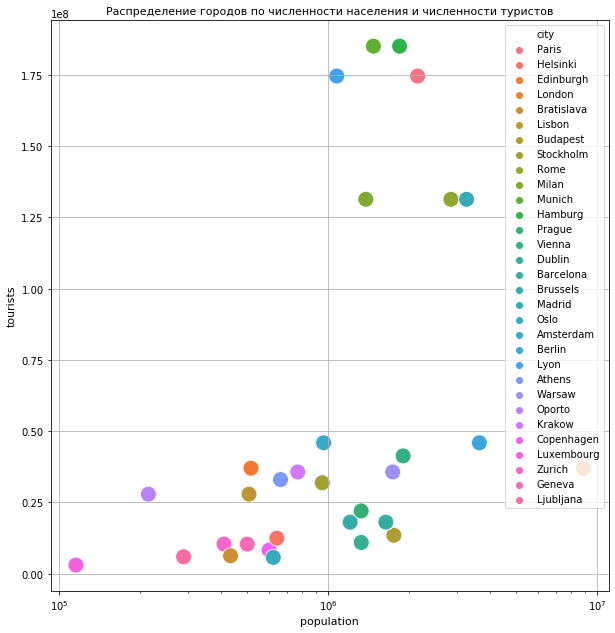

In [36]:
fig = plt.figure(figsize=(10,10.5))
g =sns.scatterplot(x='population', y='tourists',hue='city',data=data_new, s=250, palette="husl");
g.set(xscale="log")
g.legend(loc="upper right")
plt.xlabel('population', fontsize=11, color='black')
plt.ylabel('tourists', fontsize=11, color='black')
plt.title('Распределение городов по численности населения и численности туристов', fontsize=11, color='black')
plt.grid(True)
plt.show()

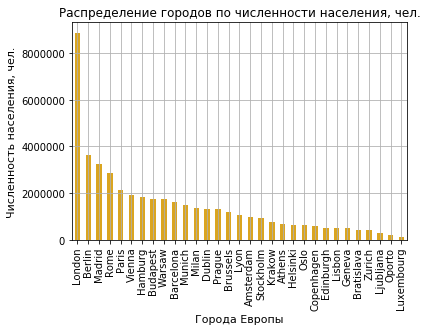

In [37]:
bar_groupby('city','population','Распределение городов по численности населения, чел.','Города Европы',
            'Численность населения, чел.')

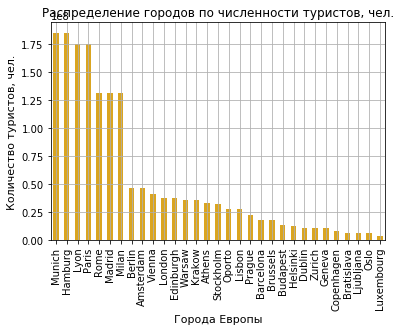

In [38]:
bar_groupby('city','tourists','Распределение городов по численности туристов, чел.','Города Европы',
            'Количество туристов, чел.')

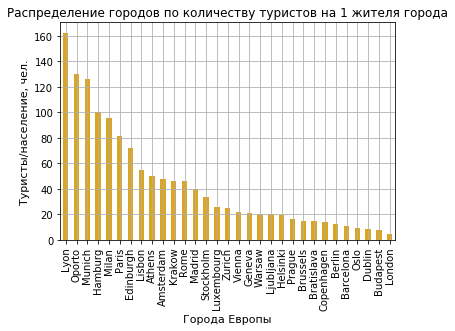

In [39]:
bar_groupby('city','tourists/population','Распределение городов по количеству туристов на 1 жителя города','Города Европы',
            'Туристы/население, чел.')

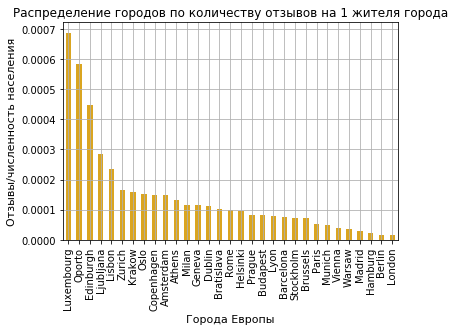

In [40]:
bar_groupby('city','number_of_reviews/population','Распределение городов по количеству отзывов на 1 жителя города','Города Европы',
            'Отзывы/численность населения')

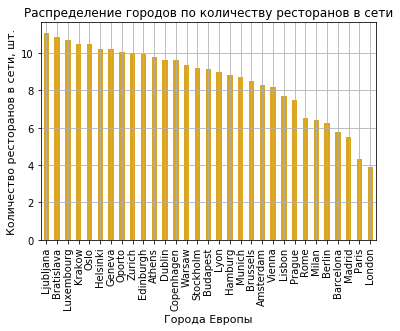

In [41]:
bar_groupby('city','chain','Распределение городов по количеству ресторанов в сети','Города Европы',
            'Количество ресторанов в сети, шт.')

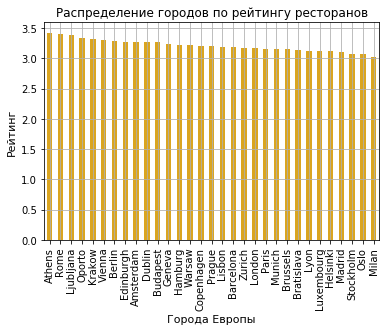

In [42]:
bar_groupby('city','rating','Распределение городов по рейтингу ресторанов','Города Европы',
            'Рейтинг')

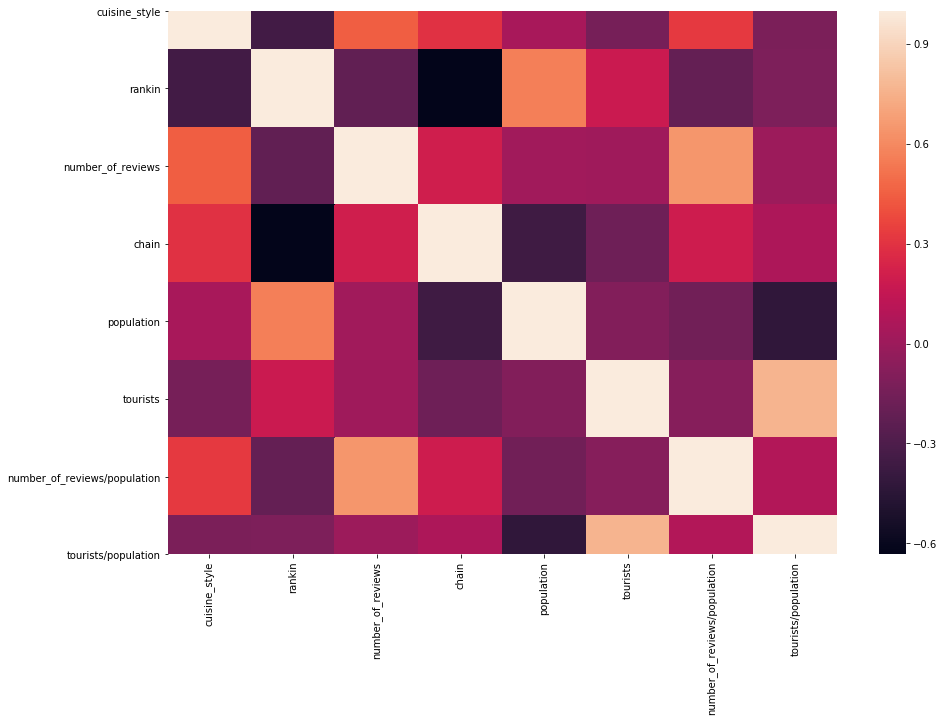

In [43]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data_new[['cuisine_style','rankin','number_of_reviews','chain','population','tourists',
                      'number_of_reviews/population','tourists/population']].corr(),)

### 6. Предварительная обработка данных

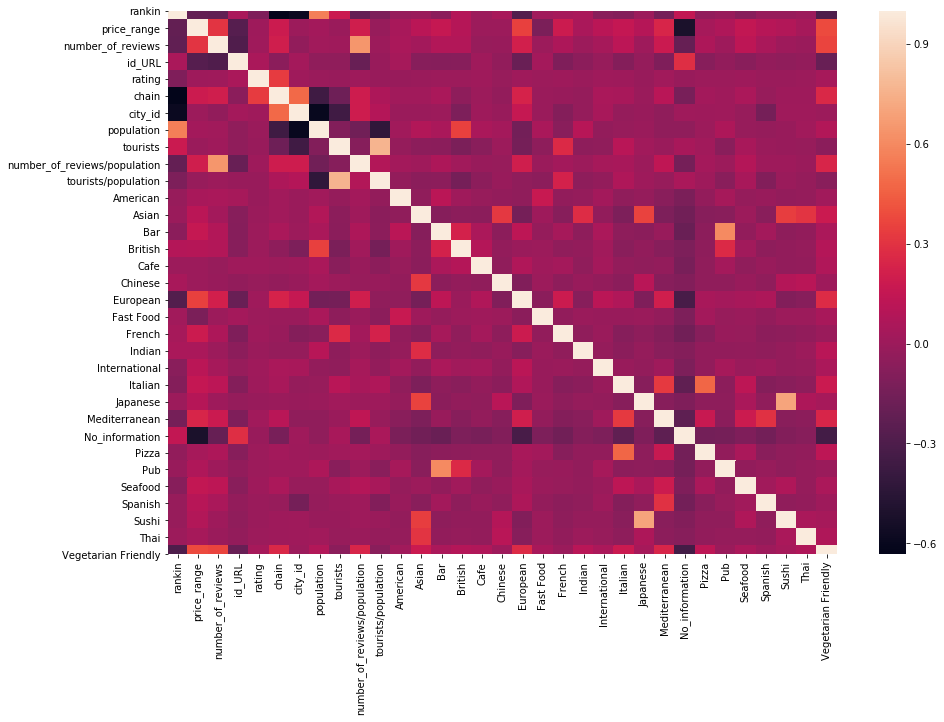

In [44]:
# Удаляем номинальные признаки
data_new.drop(['URL'], axis='columns', inplace=True)
data_new.drop('reviews', axis='columns', inplace=True)
data_new.drop('last_rew', axis='columns', inplace=True)
data_new.drop('city', axis='columns', inplace=True)
data_new.drop('country', axis='columns', inplace=True)
data_new.drop('id', axis='columns',inplace=True)
data_new.drop('cuisine_style', axis='columns',inplace=True)
data_new.drop('last_rew_data', axis='columns',inplace=True)
plt.rcParams['figure.figsize'] = (15,10)

# Строим корреляционную карту
sns.heatmap(data_new.drop(['sample'], axis=1).corr(),)

In [45]:
# Выводим итоговую предобработанную таблицу
pd.options.display.max_info_columns 
data_new.info(verbose=True, max_cols=False, null_counts=True)
data_new.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 34 columns):
rankin                          50000 non-null float64
price_range                     50000 non-null float64
number_of_reviews               50000 non-null float64
id_URL                          50000 non-null int64
rating                          50000 non-null float64
sample                          50000 non-null object
chain                           50000 non-null int64
city_id                         50000 non-null int64
population                      50000 non-null float64
tourists                        50000 non-null int64
number_of_reviews/population    50000 non-null float64
tourists/population             50000 non-null float64
American                        50000 non-null int64
Asian                           50000 non-null int64
Bar                             50000 non-null int64
British                         50000 non-null int64
Cafe                        

,rankin,price_range,number_of_reviews,id_URL,rating,sample,chain,city_id,population,tourists,number_of_reviews/population,tourists/population,American,Asian,Bar,British,Cafe,Chinese,European,Fast Food,French,Indian,International,Italian,Japanese,Mediterranean,No_information,Pizza,Pub,Seafood,Spanish,Sushi,Thai,Vegetarian Friendly
0,12963.0,2.0,4.0,10746918,0.0,test,16,1,2148000.0,174628055,0.000002,81.297977,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,106.0,2.0,97.0,6674944,0.0,test,10,27,643272.0,12426677,0.000151,19.317920,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,810.0,2.0,28.0,13129638,0.0,test,15,21,515855.0,37000000,0.000054,71.725582,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1669.0,3.0,202.0,680417,0.0,test,9,0,8866541.0,37000000,0.000023,4.172991,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
4,37.0,3.0,162.0,1112354,0.0,test,14,28,432864.0,6267801,0.000374,14.479839,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1


In [46]:
# Из общего датасета снова выделим тестовую и тренировочную часть
train_data = data_new.query('sample == "train"').drop(['sample'], axis=1)
test_data = data_new.query('sample == "test"').drop(['sample'], axis=1)

# Целевая переменная
y = train_data.rating.values

# Прочие переменные
X = train_data.drop(['rating'], axis=1)

In [47]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# Выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [48]:
# Проверка
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 33), (40000, 33), (40000, 32), (32000, 32), (8000, 32))

### 7. Модель

In [49]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [50]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [51]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.206279375


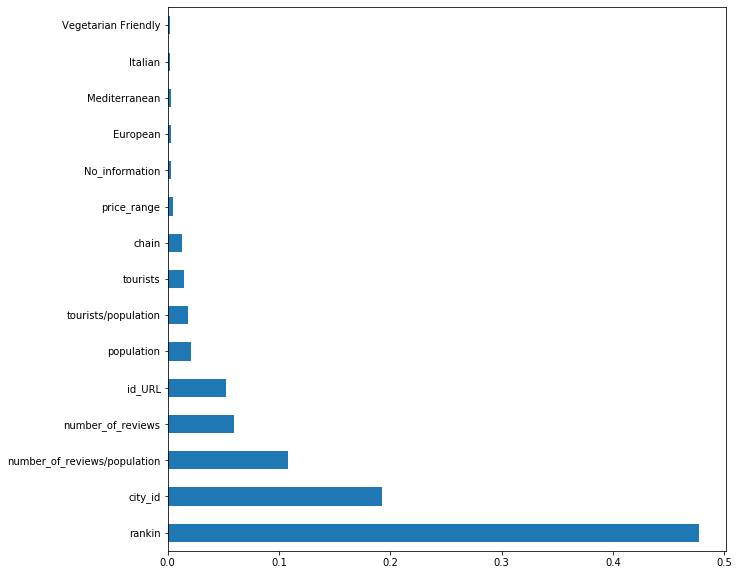

In [52]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

### 8. Итог

In [53]:
test_data.sample(10)
test_data = test_data.drop(['rating'], axis=1)

In [54]:
len(test_data)

10000

In [55]:
len(sample_submission)

10000

In [56]:
predict_submission = model.predict(test_data)
len(predict_submission)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


10000

In [57]:
def round_nearest(x, a):
    return round(x / a) * a
sample_submission['rating'] = predict_submission.round(1)
sample_submission['rating'] = round_nearest(sample_submission['Rating'], 0.5)
sample_submission.head(10)
sample_submission.to_csv('submission.csv', index=False)